# Домашнее задание «Элементарные методы анализа временных рядов»
Взять из прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline
from sklearn.metrics import mean_squared_error

Изначально пропишем функции, которые будут использоваться для анализа временных рядов.

In [2]:
# Функция, являющаяся тестом на стационарность ряда
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [3]:
# Функция, позволяющая визуализировать графики
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

In [4]:
# Загружаем временной ряд
series = pd.read_csv('international-airline-passengers.csv')['Count']

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


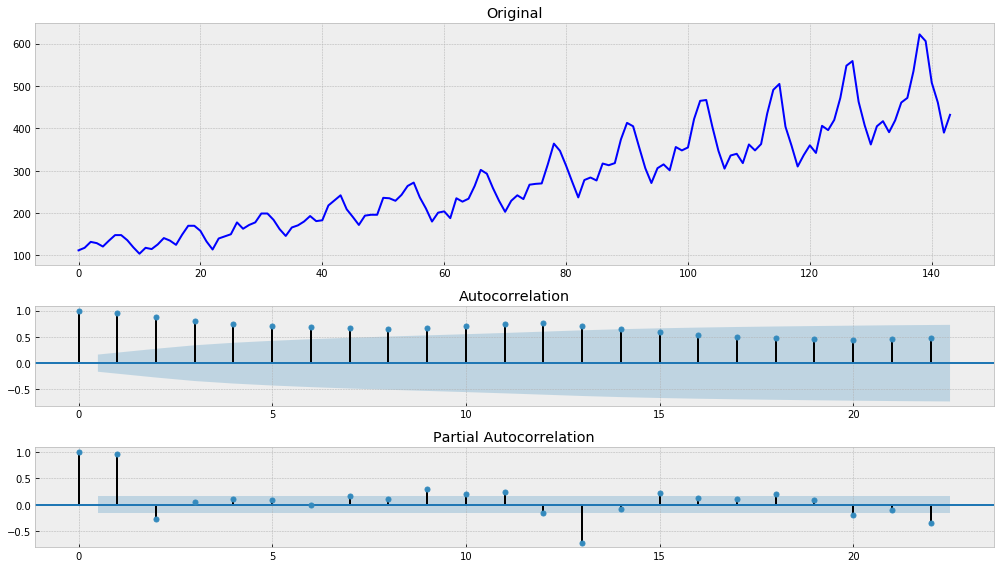

In [5]:
# Проводим анализ функции
tsplot(series)

Данный временной ряд обладает сезонностью и трендом.

In [6]:
# Делим данные на тренировочные и тестовые
train, test = series[:100], series[100:]

Метод Хольт-Винтера учитывает тренд сезонность и шум. Поэтому для предсказания будем использовать метод Хольт-Винтера.

In [7]:
# Функция, инициализирующая тренд
def initial_trend(series, season_len):
    i = 0
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [8]:
# Функция, инициализирующая сезонные компоненты
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # Определяем средние сезонные значения
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # Определяем начальные значения
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [9]:
# Функция, осуществляющая тройное экспоненциальное сглаживание
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # инициализируем значения (первая итерация)
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # Предсказываем
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [10]:
# Визуализирующая функция
def plot_tema(alpha, beta, gamma, ser=train, ser_to_plot=test, n_preds=44):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser, color='black',label='train')
        plt.plot(ser_to_plot, color='blue',label='test')
        plt.plot(tema, color='red', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

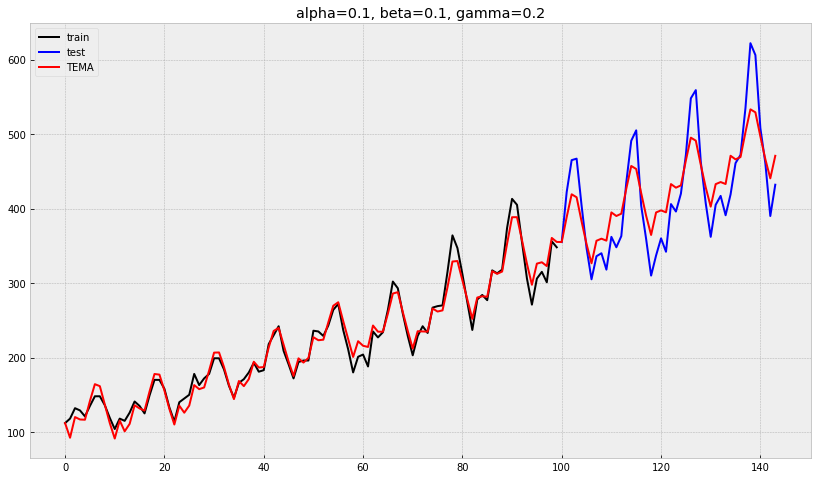

In [11]:
# Строим предсказание
plot_tema(0.1, 0.1, 0.2)

In [12]:
# Строим предсказание
tema = triple_exponential_smoothing(train, 12, 0.1, 0.1, 0.2, 44)

In [13]:
# Определяем качество модели на предсказанных значениях
mean_squared_error(tema[100:], test) 

1470.700361940886

In [14]:
# Определяем качество модели для всех данных
mean_squared_error(tema, series) 

538.4373006374935

Преобразуем выбранный ряд в стационарный

In [15]:
# Уберём изменение дисперсии при помощи преобразования Бокса-Кокса
series = boxcox(series, 0)

In [16]:
# При помощи дифференцирования уберём тренд
series = series[1:] - series[:-1]

In [17]:
# Уберём влияние сезонности
series = series[12:] - series[:-12]

Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


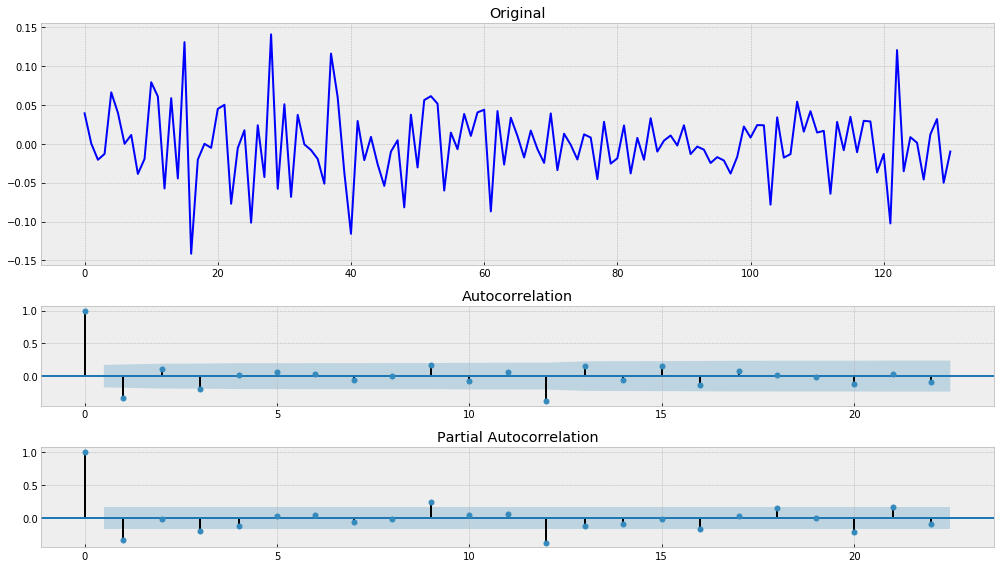

In [18]:
# Проведём анализ функции
tsplot(series)

Теперь тест Дики-Фуллера и графики коррелограмм отвергают гипотезу о нестационарности ряда.

Так как теперь временной ряд не обладает ни сезонностью, ни трендом, то не будем использовать метод Хольт-Винтера.

In [19]:
# Делим данные на тренировочные и тестовые
series = pd.DataFrame(series)[0]
train, test = series[:100], series[100:]

In [20]:
def double_ema_with_preds(series, alpha, beta, n_preds):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        
    preds = []
    for n in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)

    return series.append(pd.Series(preds), ignore_index=True), pd.Series(result)

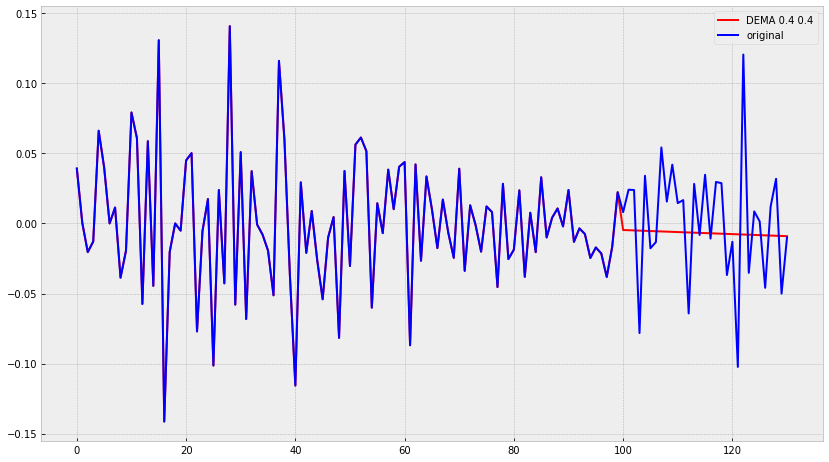

In [21]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    ser, _ = double_ema_with_preds(train, 0.1, 0.05, 31)
    plt.plot(ser, color='red', label='DEMA {} {}'.format(0.4, 0.4))
    plt.plot(series, color='blue',label='original')
    plt.legend()

In [22]:
# Определяем качество модели на предсказанных значениях
mean_squared_error(ser[100:], test) 

0.0018642388857795364

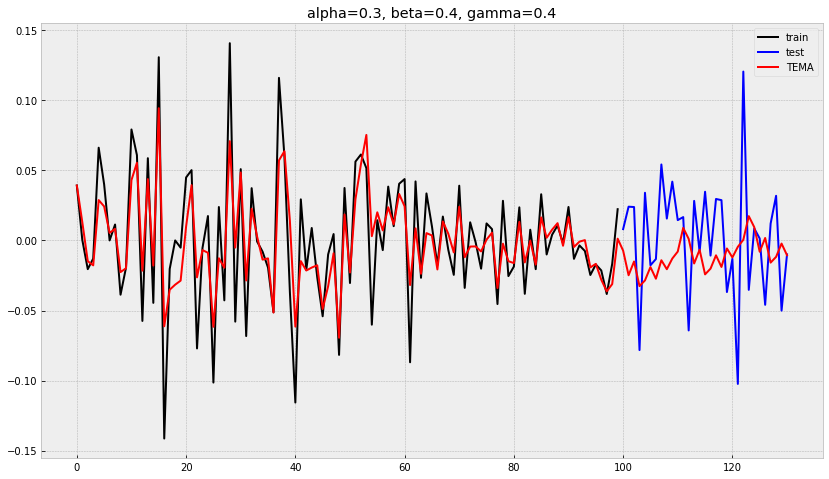

In [23]:
# Строим предсказание, используя метод Хольт-Винтера
plot_tema(0.3, 0.4, 0.4, ser=train, ser_to_plot=test, n_preds=31)

In [24]:
# Строим предсказание, используя метод Хольт-Винтера
tema = triple_exponential_smoothing(train, 12, 0.3, 0.4, 0.4, 31)

In [25]:
# Определяем качество модели на предсказанных значениях
mean_squared_error(tema[100:], test) 

0.0022135795746824924